# Demonstration of DESeq2 approximation using Robichaud et al. data

In [1]:
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
import pydeseq2 
from pydeseq2.dds import DeseqDataSet
from pydeseq2.default_inference import DefaultInference
from pydeseq2.ds import DeseqStats
import scipy

Import the squirrel liver data from https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE254223.

In [4]:
ad_raw=sc.read_csv('/home/gennady/curation-results/robichaud/GSE254223_cut_bw1-ReadCount.tab',delimiter='\t')

In [5]:
ad_raw=ad_raw.T

The data have interbout euthermia, summer, and torpor states.

In [7]:
ad_raw.obs_names.str.split('_').str[0].value_counts()

TAL    8
TSL    8
TTL    8
Name: count, dtype: int64

In [8]:
ad_raw.obs_names.str.split('_').str[0].unique().sort_values()

Index(['TAL', 'TSL', 'TTL'], dtype='object')

In [9]:
ad_raw.obs['State'] = ad_raw.obs_names.str.split('_').str[0]

Filter to a contrast between torpor and summer.

In [10]:
ad=ad_raw[ad_raw.obs['State'].isin(['TTL','TSL'])].copy()

In [11]:
ad.X=ad.X.astype(int)

This produces an `AnnData` object with eight data points per state.

In [12]:
ad

AnnData object with n_obs × n_vars = 16 × 459
    obs: 'State'

Run the exact analysis.

In [13]:
inference = DefaultInference(n_cpus=8)
dds=DeseqDataSet(adata=ad,design_factors=['State'],
    refit_cooks=True,
    inference=inference,
)

In [15]:
dds.deseq2()


Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 0.52 seconds.

Fitting dispersion trend curve...
... done in 0.03 seconds.

Fitting MAP dispersions...
... done in 0.47 seconds.

Fitting LFCs...
... done in 0.30 seconds.

Replacing 2 outlier genes.

Fitting dispersions...
... done in 0.01 seconds.

Fitting MAP dispersions...
... done in 0.01 seconds.

Fitting LFCs...
... done in 0.01 seconds.



In [16]:
ds = DeseqStats(dds, contrast=["State", 'TTL','TSL'], inference=inference)
ds.summary()
df=ds.results_df

Running Wald tests...


Log2 fold change & Wald test p-value: State TTL vs TSL
                        baseMean  log2FoldChange     lfcSE      stat  \
ENSSTOT00000016576     14.538828       -0.356129  0.342067 -1.041110   
ENSSTOT00000016579      0.796981        0.821900  1.203285  0.683047   
ENSSTOT00000016581     41.064976        0.650136  0.548890  1.184457   
ENSSTOT00000016582  14442.667801       -0.613509  0.168729 -3.636058   
ENSSTOT00000016583   3215.337101        0.375449  0.208001  1.805035   
...                          ...             ...       ...       ...   
ENSSTOT00000042713      0.000000             NaN       NaN       NaN   
ENSSTOT00000042714      0.000000             NaN       NaN       NaN   
ENSSTOT00000042902      0.000000             NaN       NaN       NaN   
ENSSTOT00000043064      0.000000             NaN       NaN       NaN   
ENSSTOT00000043200      0.000000             NaN       NaN       NaN   

                      pvalue      padj  
ENSSTOT00000016576  0.297825  0.430816 

... done in 0.60 seconds.



Plot the mean–variance relationship to check the Poisson assumption approximately holds.

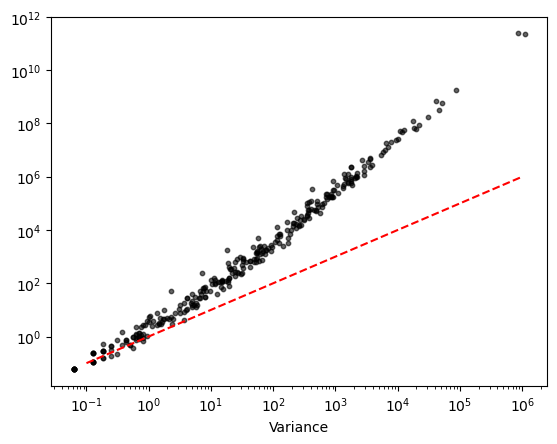

In [20]:
plt.scatter(ad.X.mean(0),ad.X.var(0),10,'k',alpha=0.6)
xl=[1e-1,1e6]
plt.plot(xl,xl,'r--')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Mean')
plt.xlabel('Variance')
plt.show()

Check the mean–dispersion relationship and plot the inferred trend, $\pm$ one OOM.

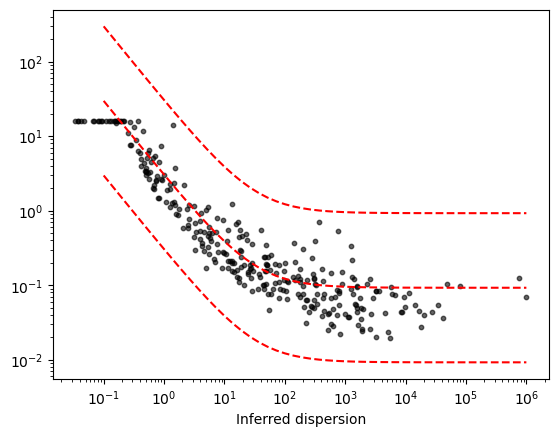

In [22]:
plt.scatter(df.baseMean,dds.varm['dispersions'],10,'k',alpha=0.6)
xl=np.logspace(-1,6)
yl=dds.uns['trend_coeffs'].a0+dds.uns['trend_coeffs'].a1/xl
plt.plot(xl,yl,'r--')
plt.plot(xl,yl*10,'r--')
plt.plot(xl,yl/10,'r--')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Mean')
plt.xlabel('Inferred dispersion')
plt.show()

Generate manuscript figure. The heuristic estimate is a reasonable estimate of the true mean–dispersion relationship.

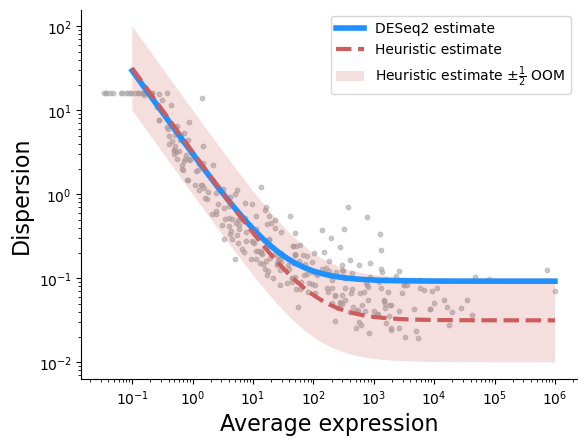

In [24]:
plt.scatter(df.baseMean,dds.varm['dispersions'],10,'darkgray',alpha=0.6)
disp_delta = 10**(1/2)
xl=np.logspace(-1,6)
yl=dds.uns['trend_coeffs'].a0+dds.uns['trend_coeffs'].a1/xl
plt.plot(xl,yl,'-',c='dodgerblue',linewidth=4,label='DESeq2 estimate')

yl=10**(-3/2)+(10**(1/2))/xl
plt.plot(xl,yl,'--',c='indianred',linewidth=3,label='Heuristic estimate')

plt.fill_between(xl,yl*disp_delta,yl/disp_delta,color='indianred',alpha=0.2,edgecolor=None,label=r'Heuristic estimate $\pm\frac{1}{2}$ OOM')
plt.xscale('log')
plt.legend()
plt.yscale('log')
fs=16
plt.xlabel('Average expression',fontsize=fs)
plt.ylabel('Dispersion',fontsize=fs)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)


Compare the log-fold changes obtained by running the full procedure and by simply taking the ratio of means. As expected, they are fairly close, but ignoring the size factors does inject some error. 

/tmp/ipykernel_119311/4047443570.py:1: RuntimeWarning: divide by zero encountered in divide
  plt.scatter( df.log2FoldChange,np.log2(ad[ad.obs.State=='TTL'].X.mean(0)/ad[ad.obs.State=='TSL'].X.mean(0)),3,'k')
/tmp/ipykernel_119311/4047443570.py:1: RuntimeWarning: invalid value encountered in divide
  plt.scatter( df.log2FoldChange,np.log2(ad[ad.obs.State=='TTL'].X.mean(0)/ad[ad.obs.State=='TSL'].X.mean(0)),3,'k')
/tmp/ipykernel_119311/4047443570.py:1: RuntimeWarning: divide by zero encountered in log2
  plt.scatter( df.log2FoldChange,np.log2(ad[ad.obs.State=='TTL'].X.mean(0)/ad[ad.obs.State=='TSL'].X.mean(0)),3,'k')


Text(0, 0.5, 'log2 fold change obtained by ratio of means')

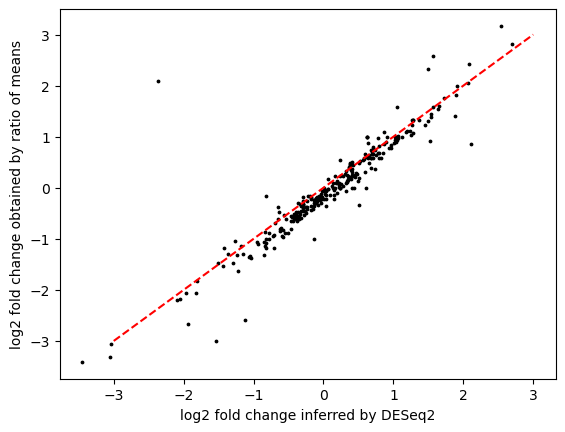

In [25]:
plt.scatter( df.log2FoldChange,np.log2(ad[ad.obs.State=='TTL'].X.mean(0)/ad[ad.obs.State=='TSL'].X.mean(0)),3,'k')
xl = -3,3
plt.plot(xl,xl,'r--')
plt.xlabel('log2 fold change inferred by DESeq2')
plt.ylabel('log2 fold change obtained by ratio of means')


The `baseMean` statistics are (approximately) the average of size factor-normalized counts.

Text(0, 0.5, 'basemean obtained by mean of normalized counts')

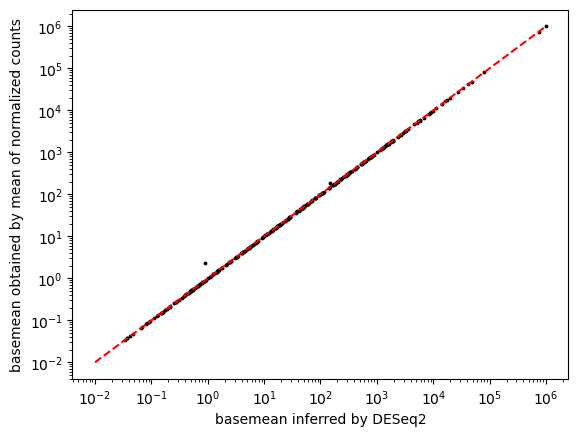

In [41]:
plt.scatter( df.baseMean,ad.layers['normed_counts'].mean(0),3,'k')
xl = 1e-2,1e6
plt.plot(xl,xl,'r--')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('basemean inferred by DESeq2')
plt.ylabel('basemean obtained by mean of normalized counts')


Now, we can check how well the assumptions made in the design procedure hold. 

We *condition* on the log-fold change (which is one of the design parameters/constraints) and check how well the average expression (`baseMean`), dispersion, `lfcSE`, and the (absolute value of the) Wald statistic are recapitulated.

The error bars reflect the half-OOM bounds introduced by the dispersion estimates.

/tmp/ipykernel_119311/781115441.py:38: RuntimeWarning: divide by zero encountered in divide
  W0=1/(1/mu_0+disp)
/tmp/ipykernel_119311/781115441.py:41: RuntimeWarning: divide by zero encountered in divide
  W0=1/(1/mu_0+disp_high)
/tmp/ipykernel_119311/781115441.py:44: RuntimeWarning: divide by zero encountered in divide
  W0=1/(1/mu_0+disp_low)


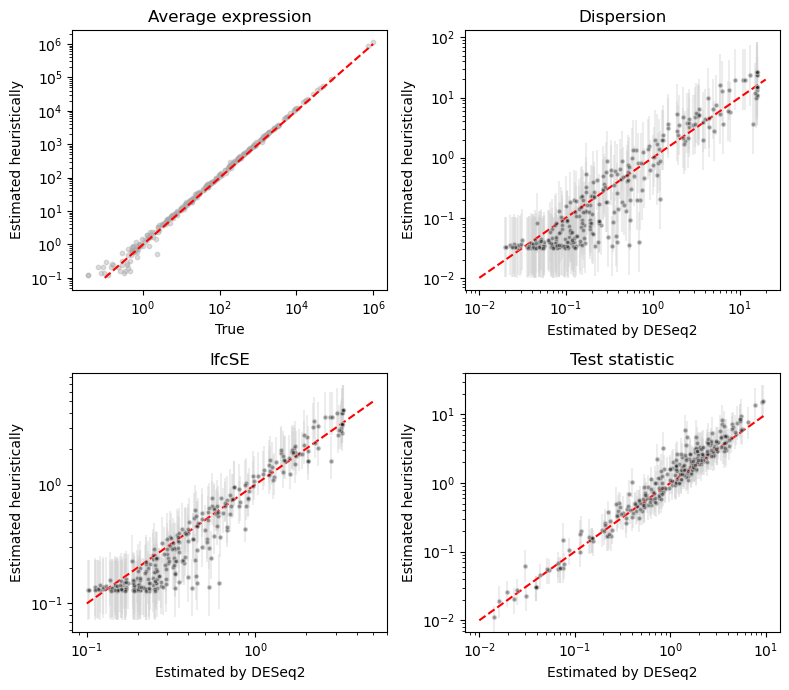

In [29]:
fig1,ax1=plt.subplots(2,2,figsize=(8,7))

# basemean
n0 = 8
n1 = 8
mu_0 = ad[ad.obs.State=='TSL'].X.mean(0)
LFC = df.log2FoldChange/np.log2(np.exp(1))
mubar = mu_0 * (1+np.exp(LFC))/2
ax1[0,0].scatter(ad.layers['normed_counts'].mean(0),mubar,10,'darkgray',alpha=0.4)
xl = 1e-1,1e6
ax1[0,0].plot(xl,xl,'r--')
ax1[0,0].set_xscale('log')
ax1[0,0].set_yscale('log')
ax1[0,0].set_title('Average expression')
ax1[0,0].set_xlabel('True')
ax1[0,0].set_ylabel('Estimated heuristically')


# dispersion
disp = 10**(-3/2)+(10**(1/2))/mubar
disp_high = disp*10**(1/2)
disp_low = disp/10**(1/2)
ax1[0,1].errorbar(x=ad.varm['dispersions'],y=disp,
                  yerr=[disp-disp_low,disp_high-disp],
                  markersize=3,marker='o',
                  color='lightgray',alpha=0.4,linestyle='',markerfacecolor='k')
xl = 1e-2,20
ax1[0,1].plot(xl,xl,'r--')
ax1[0,1].set_xscale('log')
ax1[0,1].set_yscale('log')
ax1[0,1].set_title('Dispersion')
ax1[0,1].set_xlabel('Estimated by DESeq2')
ax1[0,1].set_ylabel('Estimated heuristically')

# lfcSE
mu_1 = mu_0*np.exp(LFC)

W0=1/(1/mu_0+disp)
W1=1/(1/mu_1+disp)
lfcSE=np.sqrt(1/(W0*n0)+1/(W1*n1))/np.log(2)
W0=1/(1/mu_0+disp_high)
W1=1/(1/mu_1+disp_high)
lfcSE_high=np.sqrt(1/(W0*n0)+1/(W1*n1))/np.log(2)
W0=1/(1/mu_0+disp_low)
W1=1/(1/mu_1+disp_low)
lfcSE_low=np.sqrt(1/(W0*n0)+1/(W1*n1))/np.log(2)
ax1[1,0].errorbar(x=df['lfcSE'],y=lfcSE,
                  yerr=[lfcSE-lfcSE_low,lfcSE_high-lfcSE],
                  markersize=3,marker='o',
                  color='lightgray',alpha=0.4,linestyle='',markerfacecolor='k')
xl=1e-1,5e0
ax1[1,0].plot(xl,xl,'r--')
ax1[1,0].set_xscale('log')
ax1[1,0].set_yscale('log')
ax1[1,0].set_title('lfcSE')
ax1[1,0].set_xlabel('Estimated by DESeq2')
ax1[1,0].set_ylabel('Estimated heuristically')

# Wald statistic
W = np.abs(LFC/lfcSE)/np.log(2)
W_low = np.abs(LFC/lfcSE_high)/np.log(2)
W_high = np.abs(LFC/lfcSE_low)/np.log(2)
ax1[1,1].errorbar(x=df['stat'].abs(),y=W,
                  yerr=[W-W_low,W_high-W],
                  markersize=3,marker='o',
                  color='lightgray',alpha=0.4,linestyle='',markerfacecolor='k')
xl=1e-2,1e1
ax1[1,1].plot(xl,xl,'r--')
ax1[1,1].set_xscale('log')
ax1[1,1].set_yscale('log')
ax1[1,1].set_title('Test statistic')
ax1[1,1].set_xlabel('Estimated by DESeq2')
ax1[1,1].set_ylabel('Estimated heuristically')


plt.tight_layout()


Now, we can compare the $p$-values. Since the dynamic range is quite high, we show both the raw $p$-values and their log-transformed versions.

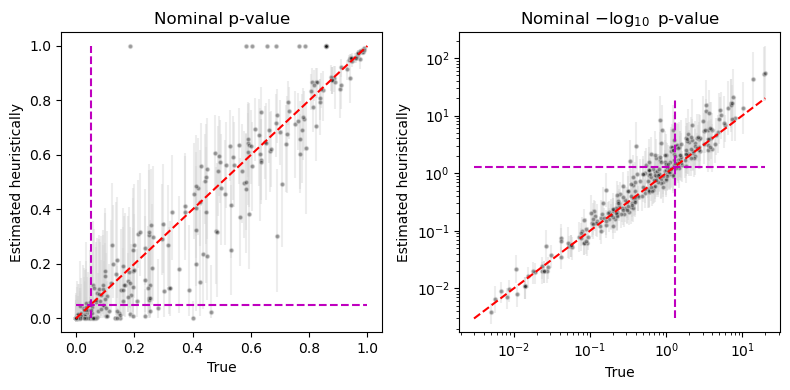

In [30]:
alpha=0.05


fig1,ax1=plt.subplots(1,2,figsize=(8,4))

# basemean
p = 2*scipy.stats.norm.sf(W.abs())
p_high = 2*scipy.stats.norm.sf(W_low.abs())
p_low = 2*scipy.stats.norm.sf(W_high.abs())
ax1[0].errorbar(x=df['pvalue'],y=p,
                  yerr=[p-p_low,p_high-p],
                  markersize=3,marker='o',
                  color='lightgray',alpha=0.4,linestyle='',markerfacecolor='k')
xl = 0,1
ax1[0].plot(xl,xl,'r--',zorder=100)
ax1[0].plot([alpha]*2,xl,'m--',zorder=101)
ax1[0].plot(xl,[alpha]*2,'m--',zorder=101)
ax1[0].set_title('Nominal p-value')
ax1[0].set_xlabel('True')
ax1[0].set_ylabel('Estimated heuristically')

x=-np.log10(df['pvalue'])
p = -np.log10(p)
p_low = -np.log10(p_low)
p_high = -np.log10(p_high)

ax1[1].errorbar(x=x,y=p,
                  yerr=[p-p_high,p_low-p],
                  # yerr=[p-p_low,p_high-p],
                  markersize=3,marker='o',
                  color='lightgray',alpha=0.4,linestyle='',markerfacecolor='k')
xl = 3e-3,2e1
ax1[1].plot(xl,xl,'r--',zorder=100)
ax1[1].plot([-np.log10(alpha)]*2,xl,'m--',zorder=101)
ax1[1].plot(xl,[-np.log10(alpha)]*2,'m--',zorder=101)
ax1[1].set_title(r'Nominal $-\log_{10}$ p-value')
ax1[1].set_xscale('log')
ax1[1].set_yscale('log')
ax1[1].set_xlabel('True')
ax1[1].set_ylabel('Estimated heuristically')

plt.tight_layout()


Most of the error and uncertainty is due to the uncertainty in the dispersion. Although we can come up with some credible heuristic estimates, this is somewhat unavoidable: to fit the dispersion, we need data. If we use the *true* dispersion — the value inferred by the DESeq2 procedure — the error effectively vanishes.

/tmp/ipykernel_119311/604173313.py:4: RuntimeWarning: divide by zero encountered in divide
  W0_=1/(1/mu_0+dds.varm['dispersions'])
/tmp/ipykernel_119311/604173313.py:6: RuntimeWarning: divide by zero encountered in divide
  lfcSE_=np.sqrt(1/(W0_*n0)+1/(W1_*n1))/np.log(2)


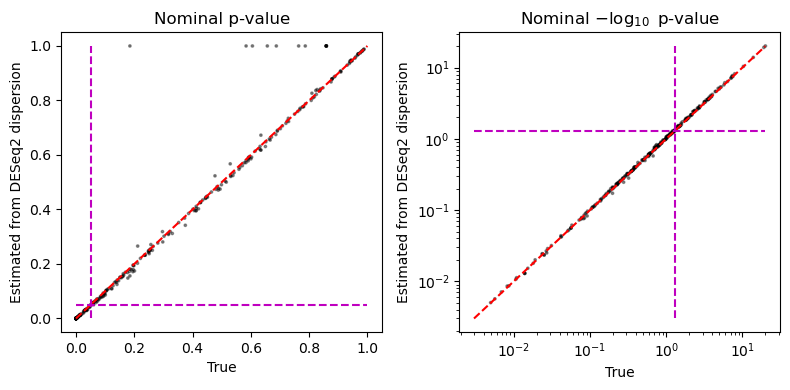

In [31]:
alpha=0.05

fig1,ax1=plt.subplots(1,2,figsize=(8,4))
W0_=1/(1/mu_0+dds.varm['dispersions'])
W1_=1/(1/mu_1+dds.varm['dispersions'])
lfcSE_=np.sqrt(1/(W0_*n0)+1/(W1_*n1))/np.log(2)
W_= np.abs(LFC/lfcSE_)/np.log(2)

# basemean
p_ = 2*scipy.stats.norm.sf(W_.abs())


ax1[0].scatter(x=df['pvalue'],y=p_,
                  s=3,marker='o',
                  color='k',alpha=0.4,linestyle='')
xl = 0,1
ax1[0].plot(xl,xl,'r--',zorder=100)
ax1[0].plot([alpha]*2,xl,'m--',zorder=101)
ax1[0].plot(xl,[alpha]*2,'m--',zorder=101)
ax1[0].set_title('Nominal p-value')
ax1[0].set_xlabel('True')
ax1[0].set_ylabel('Estimated from DESeq2 dispersion')

ax1[1].scatter(x=-np.log10(df['pvalue']),y=-np.log10(p_),
                  s=3,marker='o',
                  color='k',alpha=0.4,linestyle='')
xl = 3e-3,2e1
ax1[1].plot(xl,xl,'r--',zorder=100)
ax1[1].plot([-np.log10(alpha)]*2,xl,'m--',zorder=101)
ax1[1].plot(xl,[-np.log10(alpha)]*2,'m--',zorder=101)

ax1[1].set_title(r'Nominal $-\log_{10}$ p-value')
ax1[1].set_xscale('log')
ax1[1].set_yscale('log')
ax1[1].set_xlabel('True')
ax1[1].set_ylabel('Estimated from DESeq2 dispersion')


plt.tight_layout()
